## Libraries

In [22]:
import os, warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
from tqdm.notebook import tqdm
OMP_NUM_THREADS=1

## Loading data

- The data come from [coin gecko](https://www.coingecko.com/en/global-charts)

In [23]:
crypto_market_cap = pd.read_csv('crypto_market_cap.csv')

In [24]:
crypto_market_cap.snapped_at[1]>crypto_market_cap.snapped_at[0]

True

## Basic EDA

<Axes: >

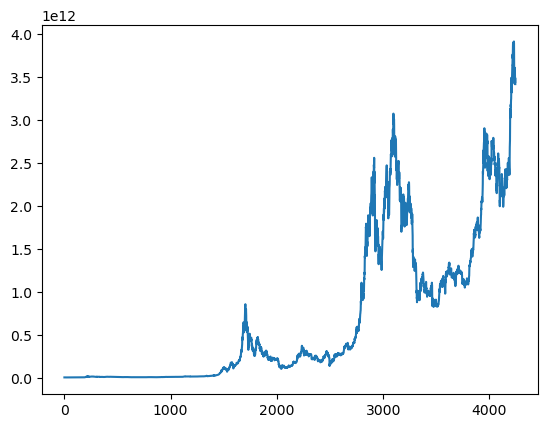

In [25]:
crypto_market_cap["market_cap"].plot(kind="line")

In [26]:
n_days = 85
conf_level = 0.99

<Axes: >

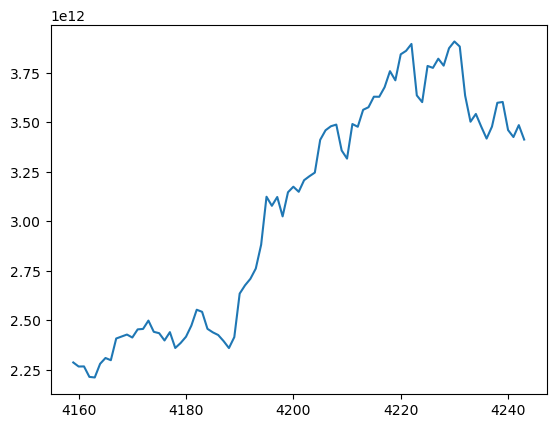

In [27]:
crypto_market_cap.tail(n_days)["market_cap"].plot(kind="line")

<Axes: xlabel='market_cap', ylabel='Density'>

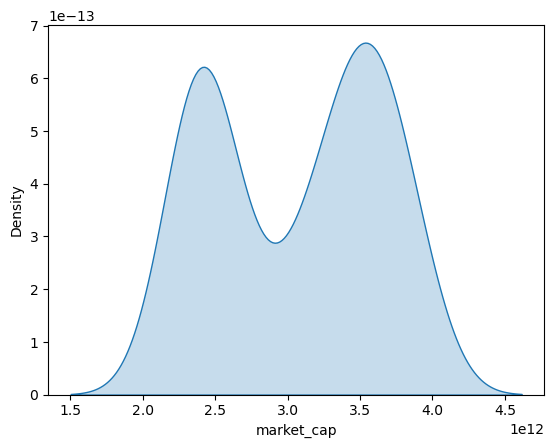

In [28]:
sns.kdeplot(crypto_market_cap["market_cap"].tail(n_days), fill=True)

In [32]:
crypto_market_cap.tail(n_days).describe()

,snapped_at,market_cap,total_volume
count,8.500000e+01,8.500000e+01,8.500000e+01
mean,1.731888e+12,3.058626e+12,2.078485e+11
std,2.132464e+09,5.734420e+11,1.126964e+11
min,1.728259e+12,2.209764e+12,5.268615e+10
25%,1.730074e+12,2.437848e+12,1.072110e+11
50%,1.731888e+12,3.173893e+12,1.972340e+11
75%,1.733702e+12,3.562647e+12,2.964516e+11
max,1.735517e+12,3.908009e+12,5.022826e+11


## Fitting a model to the market_cap data

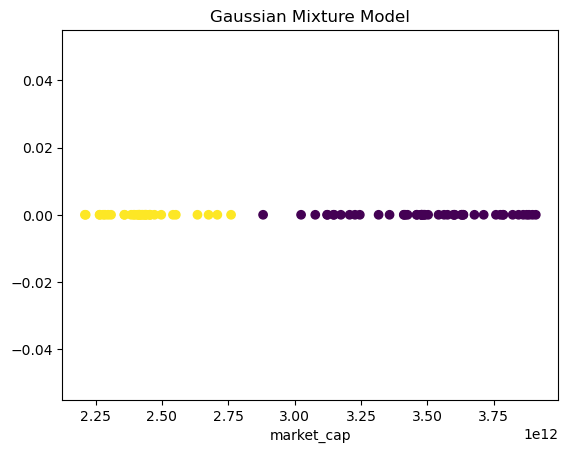

Means: [[3.49485664e+12]
 [2.42127000e+12]]
Covariances: [[[6.87090827e+22]]

 [[1.51167836e+22]]]


In [33]:
# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2)
gmm.fit(crypto_market_cap.tail(n_days)[['market_cap']])

# Predict the component for each data point
labels = gmm.predict(crypto_market_cap.tail(n_days)[['market_cap']])

# Plot the data points with different colors for each component
plt.scatter(crypto_market_cap.tail(n_days)['market_cap'], np.zeros_like(crypto_market_cap['market_cap'].tail(n_days)), c=labels, cmap='viridis')
plt.title('Gaussian Mixture Model')
plt.xlabel('market_cap')
plt.show()

# Print the means and covariances of the components
print('Means:', gmm.means_)
print('Covariances:', gmm.covariances_)

## Confidence interval for the mean

In [34]:
# Fit the initial GMM
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(crypto_market_cap[['market_cap']].tail(n_days))

# Number of bootstrap samples
n_bootstrap = 100000

# Arrays to store bootstrap estimates
bootstrap_means = np.zeros((n_bootstrap, 2))
bootstrap_covariances = np.zeros((n_bootstrap, 2))

# Perform bootstrapping
for i in tqdm(range(n_bootstrap)):
    # Resample the data with replacement
    sample = resample(crypto_market_cap[['market_cap']].tail(n_days), replace=True, n_samples=n_days)
    
    # Fit the GMM to the resampled data
    gmm_bootstrap = GaussianMixture(n_components=2, random_state=0)
    gmm_bootstrap.fit(sample)
    
    # Store the parameter estimates
    bootstrap_means[i, :] = gmm_bootstrap.means_.flatten()
    bootstrap_covariances[i, :] = gmm_bootstrap.covariances_.flatten()

# Calculate the 95% confidence intervals for the means
mean_conf_intervals = np.percentile(bootstrap_means, [2.5, 97.5], axis=0)
cov_conf_intervals = np.percentile(bootstrap_covariances, [2.5, 97.5], axis=0)

print('95% Confidence Intervals for Means:')
print(mean_conf_intervals)

print('95% Confidence Intervals for Covariances:')
print(cov_conf_intervals)

  0%|          | 0/100000 [00:00<?, ?it/s]

95% Confidence Intervals for Means:
[[2.38100312e+12 2.37823718e+12]
 [3.56474889e+12 3.55928595e+12]]
95% Confidence Intervals for Covariances:
[[5.87857748e+21 5.56003727e+21]
 [1.03998454e+23 1.02543900e+23]]


In [35]:
# Generate synthetic samples for the next day's price
n_samples = 10000
synthetic_samples = np.zeros(n_samples)

for i in range(n_samples):
    # Randomly select a bootstrap estimate
    idx = np.random.randint(n_bootstrap)
    means = bootstrap_means[idx]
    covariances = bootstrap_covariances[idx]
    
    # Randomly select a component
    component = np.random.choice([0, 1])
    
    # Generate a synthetic sample from the selected component
    synthetic_samples[i] = np.random.normal(means[component], np.sqrt(covariances[component]/np.sqrt(n_days)))

# Calculate the 95% confidence interval for the next day's market_cap
conf_interval = np.percentile(synthetic_samples, [2.5, 97.5])

print('95% Confidence Interval for the next day\'s market_cap:')
print(conf_interval)

95% Confidence Interval for the next day's market_cap:
[2.34902120e+12 3.64450118e+12]


## Monte Carlo Simulation

In [36]:

# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(crypto_market_cap[['market_cap']].tail(n_days))

# Monte Carlo simulation parameters
n_simulations = 1000000
intervals_bounds = [0, 3.2, 3.5, 3.8]

# Initialize counters
n_times_market_cap_falls_below_3_dot_2 = 0
n_times_market_cap_falls_between_3_dot_2_3_dot_5 = 0
n_times_market_cap_falls_between_3_dot_5_3_dot_8 = 0
n_times_market_cap_falls_above_3_dot_8 = 0


# Perform Monte Carlo simulation
for i in tqdm(range(n_simulations)):
    # Generate synthetic samples for the next day's market_cap using the GMM
    component = np.random.choice([0, 1], p=gmm.weights_)
    mean = gmm.means_[component][0]
    std_dev = np.sqrt(gmm.covariances_[component][0][0])/np.sqrt(n_days)
    simulated_price = np.random.normal(mean, std_dev, n_days)
    
    # Check which interval the minimum simulated price falls into
    min_price = simulated_price.min()/1e12
    if min_price < intervals_bounds[1]:
        n_times_market_cap_falls_below_3_dot_2 += 1
    elif min_price < intervals_bounds[2]:
        n_times_market_cap_falls_between_3_dot_2_3_dot_5 += 1
    elif min_price < intervals_bounds[3]:
        n_times_market_cap_falls_between_3_dot_5_3_dot_8 += 1
    else:
        n_times_market_cap_falls_above_3_dot_8 += 1
# Calculate probabilities
prob_market_cap_falls_below_3_dot_2 = n_times_market_cap_falls_below_3_dot_2 / n_simulations
prob_market_cap_falls_between_3_dot_2_3_dot_5 = n_times_market_cap_falls_between_3_dot_2_3_dot_5 / n_simulations
prob_market_cap_falls_between_3_dot_5_3_dot_8 = n_times_market_cap_falls_between_3_dot_5_3_dot_8 / n_simulations
prob_market_cap_falls_above_3_dot_8 = n_times_market_cap_falls_above_3_dot_8 / n_simulations

# Print probabilities
pd.DataFrame({
    'Probability': [round(x*100, 2) for x in [prob_market_cap_falls_below_3_dot_2, prob_market_cap_falls_between_3_dot_2_3_dot_5, prob_market_cap_falls_between_3_dot_5_3_dot_8, prob_market_cap_falls_above_3_dot_8]],
    'Interval': ['[0, 3.2)', '[3.2, 3.5)', '[3.5, 3.8)', '[3.8, inf)']
})

  0%|          | 0/1000000 [00:00<?, ?it/s]

,Probability,Interval
0,40.64,"[0, 3.2)"
1,59.36,"[3.2, 3.5)"
2,0.00,"[3.5, 3.8)"
3,0.00,"[3.8, inf)"
